# Big Data in Finance: Part II <BR><BR> Lecture Notes 6: Performance Evaluation
    
**Instructor** <BR>
Kirsten Burr, kburr26@gsb.columbia.edu
    
**TA's:** <BR>
Meha Sadasivam, MSadasivam21@gsb.columbia.edu <BR>
Daheng Yang, dyang22@gsb.columbia.edu
    
<sub> Credit: lecture notes originally developed by Lira Mota

## Up Next
1. Study the mom vs. short-term reversal strategies
2. Fama-MacBeth regressions
3. Alpha evaluation
4. Homework: Momentum 

## Momentum and Reversal

Return autocorrelations appear to be... 
1. initially negative at horizons up to a month or two (**short term reversal**),
2. then positive for horizons from 3 to 12 months (**momentum**),
3. then possibly negative again at horizons of several years (**long term reversal**).
<img src="momentum.png" width="800" height="400">

## Set Up

In [1]:
#%% Packages 
import sys
import pandas as pd
from pandas.tseries.offsets import MonthEnd

import numpy as np
import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 100) # max number or rows to be displayed 
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 6]
idx = pd.IndexSlice

In [2]:
# Packages from fire_pytools
sys.path.append("../fire_pytools") 


from utils.monthly_date import *
from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios
from import_kf.kf_factors import *
from utils.post_event_nan import * 

## Download Data

In [3]:
mdata = pd.read_pickle('../stock_monthly.pkl')
mdata.columns

Index(['permno', 'date', 'dlret', 'dlretx', 'exchcd', 'naics', 'permco', 'prc',
       'ret', 'shrcd', 'shrout', 'siccd', 'ticker', 'rankyear', 'retadj', 'me',
       'lag_me', 'lag_dlret', 'melag_weights', 'mdate', 'rf'],
      dtype='object')

In [4]:
# Clean Data
## Data start in 2010
mdata = mdata[mdata.date>='1970-01-01']
## Share type - select only common stocks 
mdata = mdata[mdata.shrcd.isin([10, 11])]
## Select stocks traded on the major stock exchanges
mdata = mdata[mdata.exchcd.isin([1, 2, 3])]
## Order
mdata = mdata.sort_values(['permno','date'])

In [5]:
# Work with excess returns
mdata['exret'] = mdata['retadj'] - mdata['rf']

In [6]:
mdata.columns

Index(['permno', 'date', 'dlret', 'dlretx', 'exchcd', 'naics', 'permco', 'prc',
       'ret', 'shrcd', 'shrout', 'siccd', 'ticker', 'rankyear', 'retadj', 'me',
       'lag_me', 'lag_dlret', 'melag_weights', 'mdate', 'rf', 'exret'],
      dtype='object')

In [7]:
mdata = mdata[['permno', 'date', 'exret', 'permco','me', 'melag_weights', 'siccd', 'exchcd']].copy()

In [8]:
mdata

,permno,date,exret,permco,me,melag_weights,siccd,exchcd
1,10000,1986-01-31,NaN,7952.0,16.100000,NaN,3990.0,3.0
2,10000,1986-02-28,-0.262439,7952.0,11.960000,16.10000,3990.0,3.0
3,10000,1986-03-31,0.359422,7952.0,16.330000,11.96000,3990.0,3.0
4,10000,1986-04-30,-0.103933,7952.0,15.172000,16.33000,3990.0,3.0
5,10000,1986-05-30,-0.227590,7952.0,11.793878,15.17200,3990.0,3.0
...,...,...,...,...,...,...,...,...
5041556,93436,2023-08-31,-0.039499,53453.0,819144.339780,848821.18368,9999.0,3.0
5041557,93436,2023-09-29,-0.034723,53453.0,795449.380000,819144.33978,9999.0,3.0
5041558,93436,2023-10-31,-0.202061,53453.0,638454.493640,795449.38000,9999.0,3.0
5041559,93436,2023-11-30,0.190955,53453.0,763195.353680,638454.49364,9999.0,3.0


In [9]:
# Create past returns
mdata['ret1'] = mdata.groupby('permno').exret.shift(1)

In [10]:
mdata[['permno','date','exret','ret1']].head()

,permno,date,exret,ret1
1,10000,1986-01-31,NaN,NaN
2,10000,1986-02-28,-0.262439,NaN
3,10000,1986-03-31,0.359422,-0.262439
4,10000,1986-04-30,-0.103933,0.359422
5,10000,1986-05-30,-0.227590,-0.103933


In [11]:
mdata[mdata.permno==10000].tail()

,permno,date,exret,permco,me,melag_weights,siccd,exchcd,ret1
14,10000,1987-02-27,-0.004309,7952.0,1.581531,1.581531,3990.0,3.0,-0.216272
15,10000,1987-03-31,-0.389627,7952.0,0.973250,1.581531,3990.0,3.0,-0.004309
16,10000,1987-04-30,-0.066785,7952.0,0.912441,0.973250,3990.0,3.0,-0.389627
17,10000,1987-05-29,-0.070427,7952.0,0.851594,0.912441,3990.0,3.0,-0.066785
18,10000,1987-06-30,-0.005031,7952.0,NaN,0.851594,3990.0,3.0,-0.070427


In [12]:
mdata['date_diff'] = mdata.groupby('permno').date.diff()

In [13]:
mdata.date_diff.describe()

count                       3197487
mean     31 days 02:30:50.217248734
std      46 days 11:00:16.865384318
min                28 days 00:00:00
25%                29 days 00:00:00
50%                31 days 00:00:00
75%                31 days 00:00:00
max             14641 days 00:00:00
Name: date_diff, dtype: object

In [14]:
mdata['date_diff']>31

TypeError: Invalid comparison between dtype=timedelta64[ns] and int

In [15]:
# How to work with dates
mdata['date_diff'].dt.days>31

1          False
2          False
3          False
4          False
5          False
           ...  
5041556    False
5041557    False
5041558     True
5041559    False
5041560    False
Name: date_diff, Length: 3222868, dtype: bool

In [16]:
# Are those problems?
mdata.loc[(mdata.date_diff.dt.days>31), ['permno','date', 'date_diff', 'exret','ret1']].head()

,permno,date,date_diff,exret,ret1
9,10000,1986-09-30,32 days,-0.061926,-0.619999
12,10000,1986-12-31,33 days,-0.382125,0.056076
15,10000,1987-03-31,32 days,-0.389627,-0.004309
18,10000,1987-06-30,32 days,-0.005031,-0.070427
28,10001,1986-09-30,32 days,-0.007860,0.067551


In [17]:
mdata.loc[(mdata.date_diff.dt.days>40), ['permno','date', 'date_diff', 'exret','ret1']].head()

,permno,date,date_diff,exret,ret1
1656,10007,1989-02-28,456 days,NaN,-0.364477
2150,10012,1987-10-30,91 days,NaN,0.072865
5489,10028,2012-11-30,245 days,-0.246609,-0.048392
9081,10050,1978-09-29,60 days,NaN,NaN
9082,10050,1978-12-29,91 days,NaN,NaN


In [18]:
mdata.loc[((mdata.permno==10028) & (mdata.date<'2012-12-30')), ['permno','date', 'date_diff', 'exret','ret1']]

,permno,date,date_diff,exret,ret1
5168,10028,1986-02-28,NaT,NaN,NaN
5169,10028,1986-03-31,31 days,0.216259,NaN
5170,10028,1986-04-30,30 days,0.176477,0.216259
5171,10028,1986-05-30,30 days,0.148912,0.176477
5172,10028,1986-06-30,31 days,-0.138579,0.148912
...,...,...,...,...,...
5478,10028,2011-12-30,30 days,-0.036129,-0.070747
5479,10028,2012-01-31,32 days,-0.026772,-0.036129
5480,10028,2012-02-29,29 days,0.081125,-0.026772
5481,10028,2012-03-30,30 days,-0.048392,0.081125


In [19]:
mdata.loc[(mdata.date_diff.dt.days>40), 'ret1'] = np.nan

In [20]:
# Calculate past returns 
def calculate_cumulative_returns(mdata, tt, min_periods):
    """
    Calculate past returns for momentum stratagy

    Parameters:
    ------------
    mdata: data frame
        crsp monthly data with cols permno, date as index.
    tt: int
        number of periods to cumulate retuns
    min_periods: int
    """
    start_time = time.time()
    required_cols = ['exret']

    assert set(required_cols).issubset(mdata.columns), "Required columns: {}.".format(', '.join(required_cols))

    df = mdata[required_cols].copy()

    # Before applying the function calculate_cumulative_returns you need to make sure 
    # we don't have missing dates. Missing dates would lead to the wrong number of periods 
    # to cumulate returns.

    # Resample data 
    # CRSP data has skipping months.
    # Create line to missing  months to facilitate the calculation of lag/past returns
    df.reset_index(inplace=True)
    df['edate'] = df['date'] + MonthEnd(0)
    df.sort_values(['permno', 'edate'], inplace=True)
    pk_integrity(df, ['permno', 'edate'])
    df.set_index(['edate'], inplace=True)
    # Resample to take care of missing months
    sdf = df[['permno', 'exret']].groupby('permno').resample('M').mean().drop(columns='permno')
    sdf.reset_index(inplace=True)
    print("Time to resample data: %s seconds" % str(time.time() - start_time))
    print("We have added %s rows to the data" % str(sdf.shape[0] - df.shape[0]))

    # Cumulative Return (adjusted) in tt months
    sdf['gret'] = sdf['exret'].fillna(0)+1
    sdf['ret_notnull'] = sdf['exret'].notnull()

    cret = sdf.groupby(['permno']).gret.rolling(window=tt, min_periods=1).apply(np.prod, raw=True)
    cret.reset_index(drop=True, inplace=True)

    nona_count = sdf.groupby(['permno']).ret_notnull.rolling(window=tt, min_periods=1).apply(np.sum, raw=True)
    nona_count.reset_index(drop=True, inplace=True)

    cret[nona_count<min_periods] = np.nan
    sdf['ret' + str(tt)] = cret

    # Delete rows that were not in the original data set
    df.reset_index(inplace=True)
    fdata = pd.merge(df,
             sdf[['edate', 'permno','ret' + str(tt)]],
             on = ['edate', 'permno'])         
    fdata.set_index(['permno','date'],inplace = True)
    x = fdata['ret' + str(tt)]

    print("Time to calculate %d months past returns: %s seconds" % (tt, str(round(time.time() - start_time, 2))))

    return x

In [21]:
## Calculate 11 months returns
mdata['ret11'] = calculate_cumulative_returns(mdata, 11, 8)

KeyError: 'date'

In [22]:
mdata.set_index(['permno','date'], inplace=True)

In [23]:
## Calculate 11 months returns
mdata['ret11'] = calculate_cumulative_returns(mdata, 11, 8)

Time to resample data: 88.47154593467712 seconds
We have added 70229 rows to the data
Time to calculate 11 months past returns: 129.77 seconds


In [24]:
# Make it investable
mdata['ret11_1'] = mdata.groupby('permno').ret11.shift(1)

In [25]:
mdata.loc[(mdata.date_diff.dt.days>40), 'ret11_1'] = np.nan

In [26]:
## Skip a month
mdata['ret11_2'] = mdata.groupby('permno').ret11_1.shift(1)

In [27]:
mdata.loc[(mdata.date_diff.dt.days>40), 'ret11_2'] = np.nan

In [28]:
mdata.reset_index(inplace=True)

### Delete missing returns

In [29]:
mdata = mdata[mdata['exret'].notnull()]

### Delete missing characteristics

In [30]:
mdata = mdata[mdata.ret11_1.notnull()]
mdata = mdata[mdata.ret11_2.notnull()]
mdata = mdata[mdata.ret1.notnull()]

## Data Summary

In [31]:
mdata[['exret', 'ret1', 'ret11_1', 'ret11_2']].describe()

,exret,ret1,ret11_1,ret11_2
count,2.937747e+06,2.937747e+06,2.937747e+06,2.937747e+06
mean,7.600908e-03,8.142094e-03,1.086385e+00,1.085981e+00
std,1.877103e-01,1.855183e-01,7.240067e-01,7.223607e-01
min,-1.014149e+00,-9.951580e-01,3.672921e-06,3.672921e-06
25%,-7.112950e-02,-7.118600e-02,7.424427e-01,7.425710e-01
50%,-3.804000e-03,-3.864000e-03,1.001387e+00,1.000512e+00
75%,6.856600e-02,6.885600e-02,1.275551e+00,1.274018e+00
max,2.399694e+01,2.399694e+01,1.066554e+02,1.066554e+02


## Forcasting Future Excess Returns

In [32]:
# FamaMacBeth regression
def ols_coef(x,formula):
    return smf.ols(formula,data=x).fit().params

def fm_summary(p):
    s = p.describe().T
    s['std_error'] = s['std']/np.sqrt(s['count'])
    s['tstat'] = s['mean']/s['std_error']
    return s[['mean','std_error','tstat']]

In [33]:
### Does ret_11_1 forcast future returns?
gamma_mom = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_1'))
gamma_mom.head()

,Intercept,ret11_1
date,,
1970-10-30,-0.188809,0.152010
1970-11-30,-0.065803,0.084473
1970-12-31,0.086035,-0.009531
1971-01-29,0.292165,-0.180847
1971-02-26,0.086903,-0.045724


<Axes: xlabel='date'>

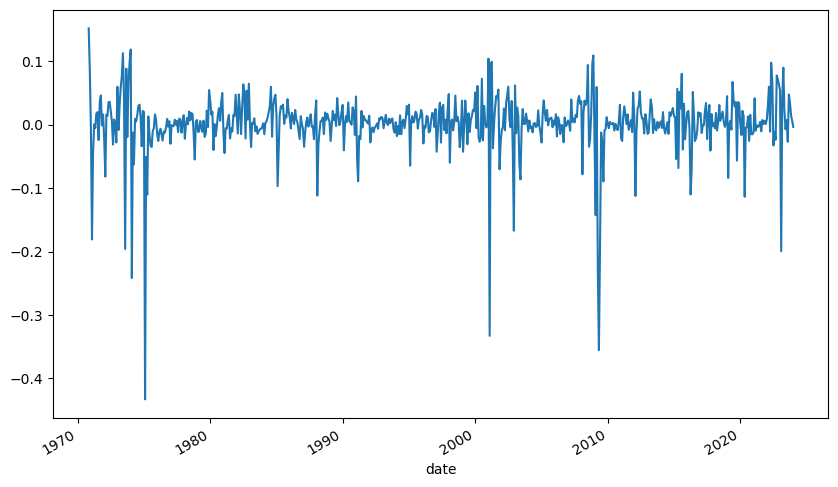

In [34]:
gamma_mom.ret11_1.plot()

In [35]:
# Fama-Macbeth regressions results
fm_summary(gamma_mom)

,mean,std_error,tstat
Intercept,0.004771,0.003284,1.453035
ret11_1,0.001997,0.001834,1.088799


### Does ret1 forcast future returns?

In [36]:
gamma_rev = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret1'))
gamma_rev.head()

,Intercept,ret1
date,,
1970-10-30,-0.033043,-0.258334
1970-11-30,0.006658,0.114236
1970-12-31,0.078616,-0.030629
1971-01-29,0.152078,-0.231513
1971-02-26,0.043502,0.002026


In [37]:
# Fama-Macbeth regressions results
fm_summary(gamma_rev) 

,mean,std_error,tstat
Intercept,0.007464,0.002291,3.258297
ret1,-0.040311,0.004101,-9.830612


### Does ret11 forcast future returns?

In [38]:
gamma_mom2 = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_2'))
gamma_mom2.head()

,Intercept,ret11_2
date,,
1970-10-30,-0.207653,0.192657
1970-11-30,-0.074125,0.090033
1970-12-31,0.084399,-0.007466
1971-01-29,0.268664,-0.174306
1971-02-26,0.088120,-0.050674


In [39]:
# Fama-Macbeth regressions results
fm_summary(gamma_mom2)

,mean,std_error,tstat
Intercept,0.001527,0.003128,0.488065
ret11_2,0.005488,0.001653,3.320728


### Do ret11_1 and ret1 forcast future returns?

In [40]:
# Fama-Macbeth regressions results
gamma = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_1 + ret1'))
fm_summary(gamma)

,mean,std_error,tstat
Intercept,0.000221,0.003070,0.071902
ret11_1,0.006532,0.001643,3.975102
ret1,-0.047627,0.003541,-13.451502


### Do ret11_2 and ret1 forcast future returns?

In [41]:
# Fama-Macbeth regressions results
gamma = (mdata[mdata.exret.notnull()].groupby('date')
                .apply(ols_coef,'exret ~ 1 + ret11_2 + ret1'))
fm_summary(gamma)

,mean,std_error,tstat
Intercept,0.001259,0.003016,0.417479
ret11_2,0.005498,0.001581,3.476922
ret1,-0.041432,0.003864,-10.722555


## Long-short portfolio

### Sort Portfolio

In [42]:
mdata['mesum'] = mdata.groupby(['date', 'permco']).me.transform(np.sum, min_count=1)

In [43]:
mdata = mdata[mdata.mesum.notnull()]

In [44]:
mdata.reset_index(inplace=True)

In [45]:
port = sort_portfolios(data = mdata,
                       quantiles={'mesum': [0.5],
                                  'ret11_2': [0.3, 0.7],
                                  'ret11_1': [0.3, 0.7],
                                  'ret1': [0.3, 0.7]},
                       id_variables=['date', 'permno', 'exchcd'],
                       exch_cd=[1])

NYSE breakpoints were calculated for mesum.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00
NYSE breakpoints were calculated for ret11_2.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00
NYSE breakpoints were calculated for ret11_1.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00
NYSE breakpoints were calculated for ret1.
Stocks were sorted according to breakpoints, starting in 1970-10-30 00:00:00


Look at the data.

In [46]:
port[port.permno==10006].head()

,date,permno,ret1portfolio,ret11_1portfolio,ret11_2portfolio,mesumportfolio
0,1970-10-30,10006.0,ret12,ret11_12,ret11_22,mesum2
2152,1970-11-30,10006.0,ret12,ret11_12,ret11_22,mesum2
4320,1970-12-31,10006.0,ret13,ret11_12,ret11_22,mesum2
6499,1971-01-29,10006.0,ret11,ret11_12,ret11_22,mesum2
8687,1971-02-26,10006.0,ret12,ret11_12,ret11_22,mesum2


### Portfolio returns

#### Merge data

In [47]:
fdata = pd.merge(mdata[['permno', 'date', 'exret', 'melag_weights']], 
                port,
                on = ['permno', 'date']) 

Have a look at Apple in 2019. Which portfolio did Apple belong to?

In [48]:
fdata[(fdata.permno==14593) & (fdata.date.dt.year>=2019)].tail(10)

,permno,date,exret,melag_weights,ret1portfolio,ret11_1portfolio,ret11_2portfolio,mesumportfolio
329934,14593,2023-03-31,0.115011,2.332313e+06,ret13,ret11_12,ret11_22,mesum2
329935,14593,2023-04-28,0.025347,2.592789e+06,ret13,ret11_12,ret11_22,mesum2
329936,14593,2023-05-31,0.042366,2.668846e+06,ret13,ret11_13,ret11_22,mesum2
329937,14593,2023-06-30,0.090252,2.787912e+06,ret13,ret11_13,ret11_23,mesum2
329938,14593,2023-07-31,0.008395,3.035217e+06,ret12,ret11_13,ret11_23,mesum2
329939,14593,2023-08-31,-0.046991,3.071345e+06,ret12,ret11_13,ret11_23,mesum2
329940,14593,2023-09-29,-0.092945,2.937203e+06,ret12,ret11_13,ret11_23,mesum2
329941,14593,2023-10-31,-0.007285,2.662326e+06,ret11,ret11_12,ret11_23,mesum2
329942,14593,2023-11-30,0.109296,2.655943e+06,ret13,ret11_13,ret11_22,mesum2
329943,14593,2023-12-29,0.009317,2.954245e+06,ret12,ret11_13,ret11_23,mesum2


#### Calculate returns

In [49]:
# Reversal Returns 
rev = fdata.groupby(['date', 
                     'mesumportfolio', 
                     'ret1portfolio']).apply(lambda x: np.average(x['exret'], 
                                                                   weights = x['melag_weights']))
display(rev)

date        mesumportfolio  ret1portfolio
1970-10-30  mesum1          ret11           -0.025202
                            ret12           -0.055249
                            ret13           -0.101283
            mesum2          ret11           -0.009772
                            ret12           -0.018604
                                               ...   
2023-12-29  mesum1          ret12            0.125492
                            ret13            0.132602
            mesum2          ret11            0.030436
                            ret12            0.038726
                            ret13            0.075740
Length: 3834, dtype: float64

In [50]:
rev = rev.unstack(level=[1, 2])
display(rev)

mesumportfolio    mesum1                        mesum2                    
ret1portfolio      ret11     ret12     ret13     ret11     ret12     ret13
date                                                                      
1970-10-30     -0.025202 -0.055249 -0.101283 -0.009772 -0.018604 -0.061833
1970-11-30     -0.007556  0.007791  0.013077  0.057785  0.055633  0.043627
1970-12-31      0.089769  0.073310  0.065054  0.077108  0.059134  0.045373
1971-01-29      0.133908  0.109467  0.076747  0.043691  0.037085  0.059520
1971-02-26      0.049126  0.032587  0.023697  0.017585  0.004421  0.011798
...                  ...       ...       ...       ...       ...       ...
2023-08-31     -0.077712 -0.068958 -0.108484 -0.013378 -0.022630 -0.026758
2023-09-29     -0.097767 -0.074892 -0.054765 -0.057360 -0.050052 -0.051091
2023-10-31     -0.116882 -0.062807 -0.077564 -0.038338 -0.026281 -0.028121
2023-11-30      0.094538  0.079226  0.055289  0.108370  0.094073  0.080053
2023-12-29      0.105234  0.125492  0.132602  0.030436  0.038726  0.075740

[639 rows x 6 columns]

In [51]:
rev_ret = rev.loc[:, idx[:, 'ret13']].mean(axis=1)-rev.loc[:, idx[:, 'ret11']].mean(axis=1)
rev_ret = rev_ret.to_frame('rev')

In [52]:
# Momentum not skipping 1-month
rev2 = fdata.groupby(['date', 
                      'mesumportfolio', 
                      'ret1portfolio']).apply(lambda x: np.average(x['exret']))
rev2 = rev2.unstack(level=[1, 2])
rev2_ret = rev2.loc[:, idx[:, 'ret13']].mean(axis=1)-rev2.loc[:, idx[:, 'ret11']].mean(axis=1)
rev2_ret = rev2_ret.to_frame('rev2')

In [53]:
# Momentum not skipping 1-month
mom2 = fdata.groupby(['date', 
                      'mesumportfolio', 
                      'ret11_1portfolio']).apply(lambda x: np.average(x['exret'], 
                                                                weights = x['melag_weights']))
mom2 = mom2.unstack(level=[1, 2])
mom2_ret = mom2.loc[:, idx[:, 'ret11_13']].mean(axis=1)-mom2.loc[:, idx[:, 'ret11_11']].mean(axis=1)
mom2_ret = mom2_ret.to_frame('mom2')

In [54]:
# Momemtum Returns
mom = fdata.groupby(['date', 
                     'mesumportfolio', 
                     'ret11_2portfolio']).apply(lambda x: np.average(x['exret'], 
                                                                weights = x['melag_weights']))
mom = mom.unstack(level=[1, 2])
mom_ret = mom.loc[:, idx[:, 'ret11_23']].mean(axis=1)-mom.loc[:, idx[:, 'ret11_21']].mean(axis=1)
mom_ret = mom_ret.to_frame('mom')

In [55]:
ret = mom_ret.join(rev_ret).join(mom2_ret).join(rev2_ret)

#### Long-short portfolio returns

<Axes: xlabel='date'>

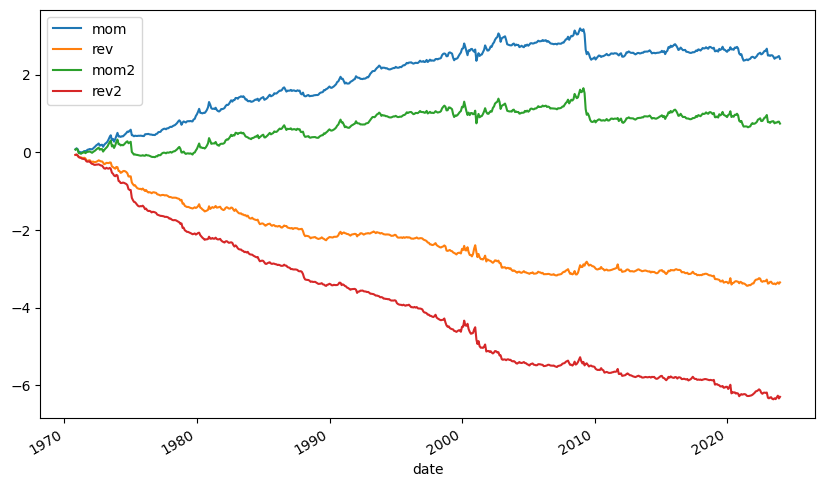

In [56]:
np.log(1+ret).cumsum().plot()

### Compare Sharpe-ratio

In [57]:
(ret.mean()/ret.std())*np.sqrt(12)

mom     0.385546
rev    -0.497134
mom2    0.171694
rev2   -0.934393
dtype: float64

## Are there alphas?

In [58]:
# FF five factor
ff = kf_factors(ff_factor_file='F-F_Research_Data_5_Factors_2x3', freq='monthly')
ff.drop(columns=['date'], inplace=True)
ff_ret = ff.set_index('mdate')/100
ff_ret.rename(columns = {'Mkt-RF': 'MktRF'}, inplace=True)

In [59]:
ff

,Mkt-RF,SMB,HML,RMW,CMA,RF,mdate
0,-0.39,-0.41,-0.97,0.68,-1.18,0.27,196307
1,5.07,-0.80,1.80,0.36,-0.35,0.25,196308
2,-1.57,-0.52,0.13,-0.71,0.29,0.27,196309
3,2.53,-1.39,-0.10,2.80,-2.01,0.29,196310
4,-0.85,-0.88,1.75,-0.51,2.24,0.27,196311
...,...,...,...,...,...,...,...
721,-2.39,-3.65,-1.06,3.43,-2.37,0.45,202308
722,-5.24,-1.80,1.52,1.86,-0.83,0.43,202309
723,-3.19,-4.04,0.19,2.46,-0.66,0.47,202310
724,8.84,-0.12,1.64,-3.91,-1.00,0.44,202311


In [60]:
ret.reset_index(inplace=True) 
ret['mdate'] = ret.date.dt.year * 100 +  ret.date.dt.month 

In [61]:
ret.set_index('mdate', inplace=True)

In [62]:
# Merge 
ret = ret.join(ff_ret)
ret.reset_index(inplace=True)
ret.set_index('date', inplace=True)

In [63]:
ret.head()

,mdate,mom,rev,mom2,rev2,MktRF,SMB,HML,RMW,CMA,RF
date,,,,,,,,,,,
1970-10-30,197010,0.083603,-0.064071,0.073112,-0.062213,-0.0228,-0.0443,0.0022,0.0171,0.0234,0.0046
1970-11-30,197011,0.023131,0.003238,0.023705,0.009349,0.0460,-0.0386,0.0169,0.0157,0.0147,0.0046
1970-12-31,197012,-0.022009,-0.028225,-0.034313,-0.024298,0.0572,0.0294,0.0100,0.0027,0.0030,0.0042
1971-01-29,197101,-0.070859,-0.020666,-0.076117,-0.045204,0.0484,0.0754,0.0133,-0.0199,0.0007,0.0038
1971-02-26,197102,0.003639,-0.015608,-0.002177,-0.008825,0.0141,0.0204,-0.0123,0.0062,-0.0070,0.0033


In [64]:
smf.ols('mom ~ MktRF', data=ret.loc['2010-01-01':]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     23.11
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           3.41e-06
Time:                        07:38:07   Log-Likelihood:                 330.51
No. Observations:                 168   AIC:                            -657.0
Df Residuals:                     166   BIC:                            -650.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0034      0.003      1.271      0.206      -0.002       0.009
MktRF         -0.2848      0.059     -4.807      0.000      -0.402      -0.168
==============================================================================
Omnibus:                       21.988   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.176
Skew:                          -0.680   Prob(JB):                     1.39e-08
Kurtosis:                       4.821   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
smf.ols('mom ~ MktRF', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     27.90
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           1.75e-07
Time:                        07:38:07   Log-Likelihood:                 1126.4
No. Observations:                 639   AIC:                            -2249.
Df Residuals:                     637   BIC:                            -2240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0059      0.002      3.553      0.000       0.003       0.009
MktRF         -0.1897      0.036     -5.283      0.000      -0.260      -0.119
==============================================================================
Omnibus:                      225.570   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1918.925
Skew:                          -1.325   Prob(JB):                         0.00
Kurtosis:                      11.065   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
smf.ols('mom ~ MktRF + SMB + HML', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     22.96
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           4.03e-14
Time:                        07:38:07   Log-Likelihood:                 1145.6
No. Observations:                 639   AIC:                            -2283.
Df Residuals:                     635   BIC:                            -2265.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0071      0.002      4.373      0.000       0.004       0.010
MktRF         -0.2223      0.037     -6.010      0.000      -0.295      -0.150
SMB           -0.0705      0.055     -1.282      0.200      -0.178       0.037
HML           -0.3202      0.053     -6.046      0.000      -0.424      -0.216
==============================================================================
Omnibus:                      222.717   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1849.549
Skew:                          -1.312   Prob(JB):                         0.00
Kurtosis:                      10.911   Cond. No.                         36.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
smf.ols('mom ~ MktRF + SMB + HML + RMW + CMA', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mom   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     18.35
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           4.95e-17
Time:                        07:38:07   Log-Likelihood:                 1156.0
No. Observations:                 639   AIC:                            -2300.
Df Residuals:                     633   BIC:                            -2273.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0054      0.002      3.264      0.001       0.002       0.009
MktRF         -0.1682      0.038     -4.380      0.000      -0.244      -0.093
SMB           -0.0235      0.058     -0.405      0.685      -0.138       0.090
HML           -0.5279      0.071     -7.442      0.000      -0.667      -0.389
RMW            0.1870      0.076      2.464      0.014       0.038       0.336
CMA            0.4553      0.111      4.092      0.000       0.237       0.674
==============================================================================
Omnibus:                      210.318   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1670.706
Skew:                          -1.237   Prob(JB):                         0.00
Kurtosis:                      10.525   Cond. No.                         78.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Should we add Reversal to our portfolio?

In [68]:
smf.ols('rev ~ MktRF + SMB + HML + RMW + CMA + mom', data=ret).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rev   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     24.53
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           3.41e-26
Time:                        07:38:07   Log-Likelihood:                 1346.8
No. Observations:                 639   AIC:                            -2680.
Df Residuals:                     632   BIC:                            -2648.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0047      0.001     -3.793      0.000      -0.007      -0.002
MktRF         -0.1594      0.029     -5.509      0.000      -0.216      -0.103
SMB           -0.1146      0.043     -2.658      0.008      -0.199      -0.030
HML           -0.1059      0.055     -1.929      0.054      -0.214       0.002
RMW            0.0056      0.057      0.099      0.921      -0.106       0.117
CMA            0.2034      0.084      2.430      0.015       0.039       0.368
mom            0.1822      0.030      6.173      0.000       0.124       0.240
==============================================================================
Omnibus:                       87.672   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              896.232
Skew:                          -0.073   Prob(JB):                    2.43e-195
Kurtosis:                       8.800   Cond. No.                         80.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
ret.drop(columns='mdate', inplace = True)

<Axes: xlabel='date'>

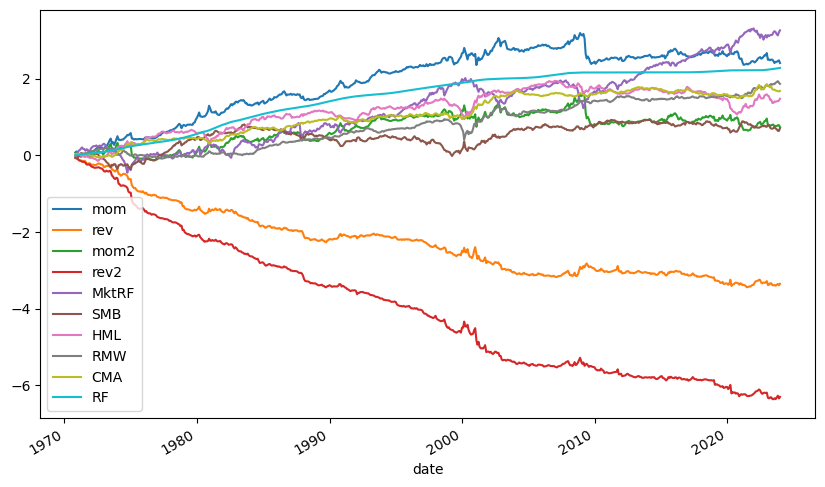

In [70]:
np.log(1+ret).cumsum().plot()

## Optimal Portfolio

In [71]:
Sigma = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA']].cov()
mu = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA']].mean()

w_mve = np.dot(np.linalg.inv(Sigma), mu)
print('Optimal portfolio weights: \n', w_mve, end='\n\n')
r_mve = (ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA']]* w_mve).sum(axis=1)
print('Optimal portfolio returns: \n', r_mve, end='\n\n')
print('Optimal portfolio SR: ', 
      np.sqrt(12) * r_mve.mean()/r_mve.std(), end='\n\n')

Optimal portfolio weights: 
 [ 5.13654911  2.79954444 -2.18195051  9.35856737 12.7281378 ]

Optimal portfolio returns: 
 date
1970-10-30    0.211936
1970-11-30    0.425377
1970-12-31    0.417750
1971-01-29    0.253349
1971-02-26    0.125300
                ...   
2023-08-31   -0.182476
2023-09-29   -0.284287
2023-10-31   -0.134888
2023-11-30   -0.078274
2023-12-29    0.226964
Length: 639, dtype: float64

Optimal portfolio SR:  1.0743842836441742



In [72]:
Sigma_mom = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']].cov()
mu_mom = ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']].mean()

w_mve_mom = np.dot(np.linalg.inv(Sigma_mom), mu_mom)
print('Optimal portfolio weights: \n', w_mve_mom, end='\n\n')
r_mve_mom = (ret[['MktRF', 'SMB', 'HML', 'RMW', 'CMA', 'mom']]* w_mve_mom).sum(axis=1)
print('Optimal portfolio returns: \n', r_mve_mom, end='\n\n')
print('Optimal portfolio SR: ', 
      np.sqrt(12) * r_mve_mom.mean()/r_mve_mom.std(), end='\n\n')

Optimal portfolio weights: 
 [ 5.71203046  2.88007974 -0.37574911  8.71874864 11.17008589  3.4218054 ]

Optimal portfolio returns: 
 date
1970-10-30    0.437896
1970-11-30    0.525466
1970-12-31    0.389387
1971-01-29    0.080475
1971-02-26    0.132234
                ...   
2023-08-31   -0.091482
2023-09-29   -0.293317
2023-10-31   -0.082429
2023-11-30    0.105594
2023-12-29    0.112578
Length: 639, dtype: float64

Optimal portfolio SR:  1.1727775169916734

